# Dự báo khách hàng rời bỏ dịch vụ không? (Customer Churn)

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder



# 1.1  Chuẩn bị dữ liệu (bao gồm xử lý missing values nếu cần, chuyển đổi biến phân loại thành số bằng kỹ thuật One-Hot Encoding hoặc Label Encoding,...). Xây dựng một mô hình với thuật toán Logistic Regression để dự đoán khả năng khách hàng rời bỏ dịch vụ.Đánh giá mô hình bằng các độ đo Accuracy, Precision, Recall, F1-score và vẽ Confusion Matrix.




In [49]:
# Đọc dữ liệu
df=pd.read_csv(r'telco_customer_churn.csv')
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
# Thay đổi giá trị "No phone service" thành "No" cột MultipleLines
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [51]:
# Các cột cần thay đổi
columns_to_change = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Thay đổi giá trị "No internet service" thành "No"
df[columns_to_change] = df[columns_to_change].applymap(lambda x: 'No' if x == 'No internet service' else x)

df.head()


,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### * Cột id gây nhiễu mô hình và không mang thông tin hữu ích => loại bỏ cột id


In [52]:
# Xóa cột ID khỏi dataframe 
df = df.drop('CustomerID', axis=1)
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Xem sơ bộ dữ liệu

In [53]:
# Hiển thị kích thước của dataframe
df.shape


(7043, 20)

In [54]:
# Thông tin tổng quan về dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


#### Nhận xét: Các cột đầy đủ dữ liệu và không thiếu
#### Nhận xét: Ta thấy cột TotalCharges là tổng số tiền mà khách hàng đã trả cho các dịch vụ nhưng lại mang giá trị object nên ta đổi về dạng number

In [55]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').round(2)


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


#### * Nhận xét: nhìn lại thì ta thấy TotalCharges  bị thiếu 11 dữ liệu. Do ban đầu TotalCharges có dạng object dẫn tới kiểm tra không phát hiện null nhưng sau đó để chuyển về dạng số và thấy nó mang giá trị null

In [57]:
# Tính giá trị trung bình của cột TotalCharges, bỏ qua các giá trị NaN
mean_total_charges = df['TotalCharges'].mean()

# Điền các giá trị bị thiếu bằng giá trị trung bình
df['TotalCharges'] = df['TotalCharges'].fillna(mean_total_charges)

print(df.isnull().sum())


Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [58]:
# Kiểm tra trùng lặp trên toàn bộ hàng
if df.duplicated(keep=False).any():
    print("Có dữ liệu trùng lặp toàn bộ hàng trong DataFrame.")
    duplicates = df[df.duplicated(keep=False)]
else:
    print("Không có dữ liệu trùng lặp toàn bộ hàng trong DataFrame.")


Có dữ liệu trùng lặp toàn bộ hàng trong DataFrame.


In [59]:
# Tìm các hàng trùng lặp
duplicates = df[df.duplicated(keep=False)]
checked_indices = set()

# Duyệt qua từng hàng trong danh sách trùng lặp và in ra các hàng giống nhau
matching_rows = []  

for idx1 in duplicates.index:
    if idx1 in checked_indices:
        continue
    matching_indices = [idx1]
    for idx2 in duplicates.index:
        if idx2 != idx1 and idx2 not in checked_indices:
            row1 = df.loc[idx1]
            row2 = df.loc[idx2]
            if row1.equals(row2):
                matching_indices.append(idx2)
    
    # Cập nhật chỉ mục đã kiểm tra
    checked_indices.update(matching_indices)
    
    if len(matching_indices) > 1:
        print(f"Các hàng giống hoàn toàn: {matching_indices}")
        
        # Lưu các hàng trùng lặp vào danh sách để hiển thị sau
        matching_rows.append(df.loc[matching_indices])


matching_df = pd.concat(matching_rows)

# Hiển thị DataFrame chứa các hàng giống nhau
print("\nCác hàng giống nhau:")
matching_df.head()




Các hàng giống hoàn toàn: [22, 1338]
Các hàng giống hoàn toàn: [100, 1932, 5506]
Các hàng giống hoàn toàn: [542, 1491]
Các hàng giống hoàn toàn: [646, 964]
Các hàng giống hoàn toàn: [662, 3754, 5736]
Các hàng giống hoàn toàn: [690, 2713]
Các hàng giống hoàn toàn: [976, 1739]
Các hàng giống hoàn toàn: [1243, 6518]
Các hàng giống hoàn toàn: [1731, 3301]
Các hàng giống hoàn toàn: [2033, 4098]
Các hàng giống hoàn toàn: [2121, 2892]
Các hàng giống hoàn toàn: [3312, 6499]
Các hàng giống hoàn toàn: [3499, 4476]
Các hàng giống hoàn toàn: [3679, 6609]
Các hàng giống hoàn toàn: [4495, 6267]
Các hàng giống hoàn toàn: [4536, 6924]
Các hàng giống hoàn toàn: [4817, 6706]
Các hàng giống hoàn toàn: [5170, 6774]
Các hàng giống hoàn toàn: [5522, 5759]
Các hàng giống hoàn toàn: [6491, 6764]

Các hàng giống nhau:


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
22,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.15,20.15,Yes
1338,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.15,20.15,Yes
100,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.20,20.20,No
1932,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.20,20.20,No
5506,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.20,20.20,No


In [60]:
# Loại bỏ các hàng trùng lặp
df = df.drop_duplicates(duplicates, keep='first')

# Hiển thị DataFrame sau khi xử lý
print("\nDataFrame sau khi loại bỏ các hàng trùng lặp:")
df



DataFrame sau khi loại bỏ các hàng trùng lặp:


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [61]:
# Kiểm tra trùng lặp trên toàn bộ hàng
if df.duplicated(keep=False).any():
    print("Có dữ liệu trùng lặp toàn bộ hàng trong DataFrame.")
    duplicates = df[df.duplicated(keep=False)]
else:
    print("Không có dữ liệu trùng lặp toàn bộ hàng trong DataFrame.")


Không có dữ liệu trùng lặp toàn bộ hàng trong DataFrame.


In [62]:
# Thống kê dữ liệu dạng số
df.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,7021.000000,7021.000000,7021.000000,7021.000000
mean,0.162512,32.469449,64.851894,2290.342338
std,0.368947,24.534965,30.069001,2265.044153
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.750000,411.150000
50%,0.000000,29.000000,70.400000,1410.250000
75%,0.000000,55.000000,89.900000,3801.700000
max,1.000000,72.000000,118.750000,8684.800000


In [63]:
# Thống kê dữ liệu dạng object
df.describe(include='object')

,Gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021,7021
unique,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3541,3619,4911,6339,4050,3090,5002,4592,4599,4977,4314,4289,3853,4161,2359,5164


## EDA


In [64]:
# Xóa cột 'Churn' khỏi DataFrame để xác định biến định lượng và biến định tính 
df_new = df.drop(columns=['Churn'])
df_new.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


### Xác định các biến định tính và in ra

In [65]:
cat_cols = df_new.select_dtypes(include=['object']).columns
cat_cols

Index(['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [66]:
for col in cat_cols:
    print(col, df[col].nunique()) 

Gender 2
Partner 2
Dependents 2
PhoneService 2
MultipleLines 2
InternetService 3
OnlineSecurity 2
OnlineBackup 2
DeviceProtection 2
TechSupport 2
StreamingTV 2
StreamingMovies 2
Contract 3
PaperlessBilling 2
PaymentMethod 4


#### Các biến phân loại :'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod'




## Xác định biến định lượng và in thông tin

In [67]:
num_cols = df_new.select_dtypes(include=['number']).columns
num_cols

Index(['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [68]:
for col in num_cols:
    print(col, df[col].nunique()) 

SeniorCitizen 2
Tenure 73
MonthlyCharges 1585
TotalCharges 6531


#### biến phân loại: 'SeniorCitizen'

#### Biến định lượng:  'Tenure', 'MonthlyCharges', 'TotalCharges'

In [69]:
# Danh sách các cột là biến phân loại cần chuyển thành category
category_cols = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

# Chuyển đổi các cột sang kiểu category
for col in category_cols:
    df[col] = df[col].astype('category')

df.head()


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Gender            7021 non-null   category
 1   SeniorCitizen     7021 non-null   category
 2   Partner           7021 non-null   category
 3   Dependents        7021 non-null   category
 4   Tenure            7021 non-null   int64   
 5   PhoneService      7021 non-null   category
 6   MultipleLines     7021 non-null   category
 7   InternetService   7021 non-null   category
 8   OnlineSecurity    7021 non-null   category
 9   OnlineBackup      7021 non-null   category
 10  DeviceProtection  7021 non-null   category
 11  TechSupport       7021 non-null   category
 12  StreamingTV       7021 non-null   category
 13  StreamingMovies   7021 non-null   category
 14  Contract          7021 non-null   category
 15  PaperlessBilling  7021 non-null   category
 16  PaymentMethod     7021 non-nu

# output: Churn             
# input: 
* 'Gender', 'Partner', 'Dependents', 'PhoneService', 
* 'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 
* 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen'
* 'Contract','PaperlessBilling', 'PaymentMethod',
* 'Tenure', 'MonthlyCharges', 'TotalCharges'

"""
# category: 
* 'Gender', 'Partner', 'Dependents', 'PhoneService', 
* 'MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 
* 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 
* 'Contract','PaperlessBilling', 'PaymentMethod', 'SeniorCitizen' 

"""
# biến số liên tục: 'Tenure', 'MonthlyCharges', 'TotalCharges'

In [71]:
#Xem miêu tả biến số
df.describe()

,Tenure,MonthlyCharges,TotalCharges
count,7021.000000,7021.000000,7021.000000
mean,32.469449,64.851894,2290.342338
std,24.534965,30.069001,2265.044153
min,0.000000,18.250000,18.800000
25%,9.000000,35.750000,411.150000
50%,29.000000,70.400000,1410.250000
75%,55.000000,89.900000,3801.700000
max,72.000000,118.750000,8684.800000


In [72]:
# Tách y (cột mục tiêu) là 'Churn'
y = df['Churn']

# Tách X (các đặc trưng) gồm các cột khác
X = df.drop(columns=['Churn'])

# Phân loại các cột trong X
categorical_features = [
    'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen'
]

continuous_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']

# Tách riêng các biến danh mục và biến liên tục từ X nếu cần
X_categorical = X[categorical_features]
X_continuous = X[continuous_features]



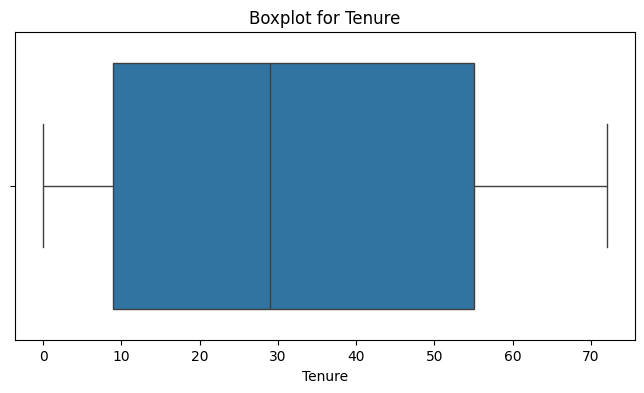

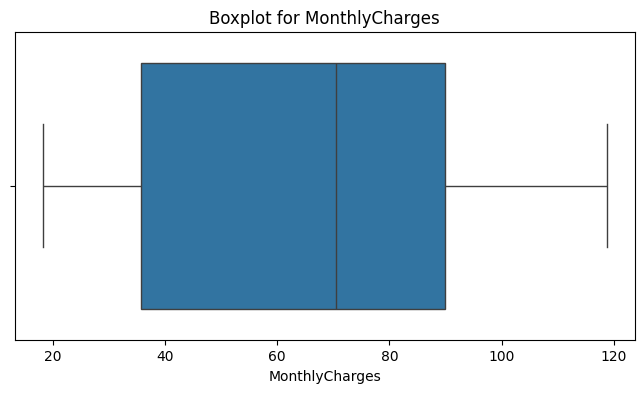

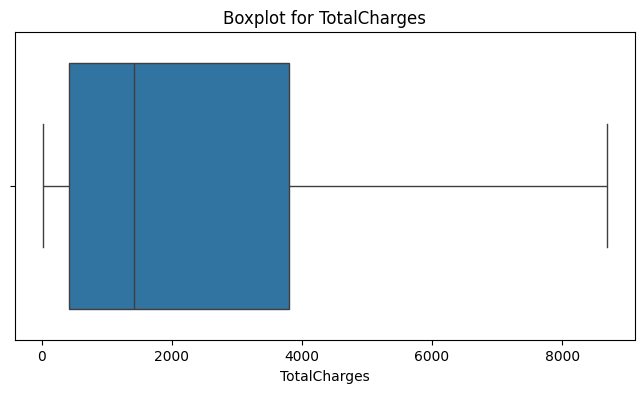

In [73]:
# Duyệt qua từng biến liên tục và vẽ boxplot
for feature in continuous_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=X_continuous, x=feature)
    plt.title(f'Boxplot for {feature}')
    plt.show()


In [74]:
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### * Nhận xét: Không thấy có outlier

In [75]:
# Mã hóa cột Churn bằng LabelEncoder
target_encoder = LabelEncoder()
df['Churn'] = target_encoder.fit_transform(df['Churn'])

#  Mã hóa các cột phân loại (categorical features)
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X['Churn']=df['Churn']
X


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,0,1,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


In [76]:
X.to_pickle('telco_customer_churn.pkl')


In [77]:
df = pd.read_pickle('telco_customer_churn.pkl')
df

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,0,1,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


In [78]:
# Tách y (cột mục tiêu) là 'Churn' sau khi mã hóa
y = df['Churn']

X = df.drop(['Churn'], axis=1)

y.shape, X.shape


((7021,), (7021, 19))

## chia dữ liệu thành tập train và test

In [79]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [80]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: [-1.68897544]
Coefficients: [[ 0.01398626  0.10707172  0.03151761 -0.09578224 -1.2626393  -0.37361685
   0.05610299 -0.03616531 -0.27520369 -0.16859074 -0.07352721 -0.28438933
  -0.04071017 -0.02762708 -0.58484551  0.13700722  0.03531662  1.01775651
   0.50809573]]


In [82]:
print('Train accuracy score:', model.score(X_train_scaled, y_train))
print('Test accuracy  score: ', model.score(X_test_scaled,y_test))

Train accuracy score: 0.8032153032153032
Test accuracy  score:  0.8020882771713337


## Đánh giá kết quả mô hình

### . Khoảng cách giữa Train và Test Accuracy
- **Train accuracy** và **test accuracy** chỉ chênh lệch **0.11%**.
- Điều này cho thấy mô hình **không bị overfitting** (quá khớp với dữ liệu huấn luyện).
- Đây là dấu hiệu tốt, vì mô hình tổng quát hóa tốt trên dữ liệu chưa từng thấy (tập test).


In [83]:
#  Sử dụng các đại lượng khác đánh giá tập test 

y_pred = model.predict(X_test_scaled)
score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.8020882771713337 0.7183042983311483 0.7455092922954225 0.5891625615763547


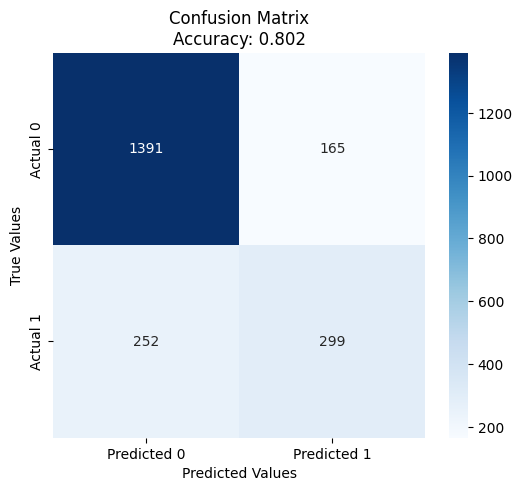

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1556
           1       0.64      0.54      0.59       551

    accuracy                           0.80      2107
   macro avg       0.75      0.72      0.73      2107
weighted avg       0.79      0.80      0.80      2107



In [84]:

# Tính confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test_scaled))
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
# Tính độ chính xác (score)
score = model.score(X_test_scaled, y_test)
# Vẽ heatmap của confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix\nAccuracy: {0:.3f}'.format(score))
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()
# In classification report
print("Classification Report:\n", classification_report(y_test, model.predict(X_test_scaled)))

# Đánh Giá Mô Hình Phân Loại

## 1. Confusion Matrix:

### Nhận Xét:
- **True Negative (TN)** khá cao, cho thấy mô hình có khả năng phân loại chính xác các mẫu **No** (Tiêu cực).
- **False Positive (FP)** và **False Negative (FN)** cần cải thiện, đặc biệt là **False Negative** (FN) cao, điều này cho thấy mô hình bỏ sót nhiều mẫu **Yes** (Tích cực).
- Cần cải thiện việc phân loại các mẫu **Yes** (Tích cực) (TP thấp).

## 2. **Classification Report:**

### Nhận Xét:
- **Precision**:
  - **Lớp No (Tiêu cực)**: Precision cao (0.85), mô hình nhận diện tốt mẫu **No**.
  - **Lớp Yes (Tích cực)**: Precision thấp (0.64), có nhiều mẫu **Yes** bị phân loại sai là **No**.
  
- **Recall**:
  - **Lớp No (Tiêu cực)**: Recall cao (0.89), mô hình có khả năng nhận diện hầu hết mẫu **No**.
  - **Lớp Yes (Tích cực)**: Recall thấp (0.54), mô hình bỏ sót nhiều mẫu **Yes**.

- **F1-Score**:
  - **Lớp No (Tiêu cực)**: F1-Score cao (0.87), mô hình hoạt động tốt với mẫu **No**.
  - **Lớp Yes (Tích cực)**: F1-Score thấp (0.59), mô hình có sự thiếu cân bằng giữa Precision và Recall đối với **Yes**.

- **Accuracy** tổng thể là **0.80**, tuy nhiên, mô hình có **Recall thấp** cho lớp **Yes**, điều này có thể gây ảnh hưởng đến các ứng dụng yêu cầu nhận diện chính xác các mẫu **Yes**.

## 3. **Nhận Xét và Đánh Giá Chung:**

- **Độ chính xác tổng thể** (Accuracy) là **80%**, khá ổn định. Tuy nhiên, mô hình cần cải thiện khả năng nhận diện mẫu **Yes**.
- **Precision cho lớp Yes** (0.64) và **Recall cho lớp Yes** (0.54) đều thấp, cho thấy mô hình bỏ sót nhiều mẫu **Yes**, đặc biệt là các mẫu quan trọng.
- **F1-Score** cho lớp **Yes** là **0.59**, thấp hơn rất nhiều so với lớp **No** (0.87), cho thấy mô hình chưa đạt hiệu quả cao đối với lớp **Yes**.


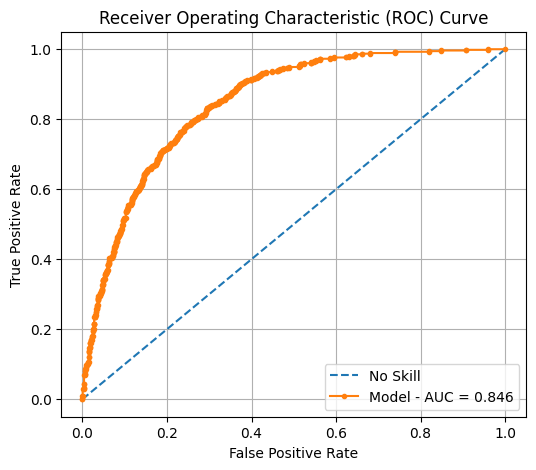

Model AUC: 0.846


In [85]:

# Tính xác suất dự đoán cho lớp 1 (positive class)
y_prob = model.predict_proba(X_test_scaled)[:, 1]
# Tính ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Tính AUC
model_auc = roc_auc_score(y_test, y_prob)
# Vẽ đường ROC
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')  # Đường baseline
plt.plot(fpr, tpr, marker='.', label='Model - AUC = %.3f' % model_auc)
# Thiết lập tiêu đề, trục và chú thích
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()
# Hiển thị kết quả AUC
print(f'Model AUC: {model_auc:.3f}')

# Đánh Giá Đường Cong ROC và AUC

## 1. **Đường Cong ROC:**
- **Đường cong màu cam** biểu diễn hiệu suất của mô hình. Nó cho thấy mối quan hệ giữa:
  - **Tỷ lệ Dương tính Thực (True Positive Rate - TPR)**: Còn gọi là độ nhạy.
  - **Tỷ lệ Dương tính Giả (False Positive Rate - FPR)**: Bằng 1 - độ đặc hiệu, ở các ngưỡng phân loại khác nhau.

## 2. **Đường Chéo "No Skill":**
- **Đường chéo màu xanh lam** thể hiện hiệu suất của một mô hình phân loại ngẫu nhiên (không có kỹ năng). Một mô hình tốt sẽ có đường cong ROC nằm trên đường chéo này.

## 3. **Giá trị AUC = 0.846:**
- AUC là diện tích dưới đường cong ROC. Nó có giá trị từ 0 đến 1, trong đó:
  - **AUC = 1**: Mô hình hoàn hảo.
  - **AUC = 0.5**: Mô hình không tốt hơn việc đoán ngẫu nhiên (tương ứng với đường chéo "No Skill").
  - **AUC < 0.5**: Mô hình hoạt động tệ hơn cả đoán ngẫu nhiên .

## 4. **Nhận Xét Cụ Thể Về Hình Ảnh:**

- **Hiệu suất tốt:** Với **AUC = 0.846**, mô hình được đánh giá là có hiệu suất tốt. Đường cong ROC nằm trên đường chéo "No Skill" một cách rõ rệt, cho thấy mô hình phân biệt tốt giữa hai lớp.
- **Đường cong dốc:** Phần đầu của đường cong ROC khá dốc, cho thấy mô hình có thể đạt được **TPR cao** với **FPR tương đối thấp**. Đây là một dấu hiệu tốt.


## 5. **Tóm Lại:**
Mô hình có **AUC = 0.846** cho thấy khả năng phân loại tốt. Tuy nhiên, tùy thuộc vào ứng dụng cụ thể, có thể cần cải thiện thêm để đạt được hiệu suất cao hơn. 


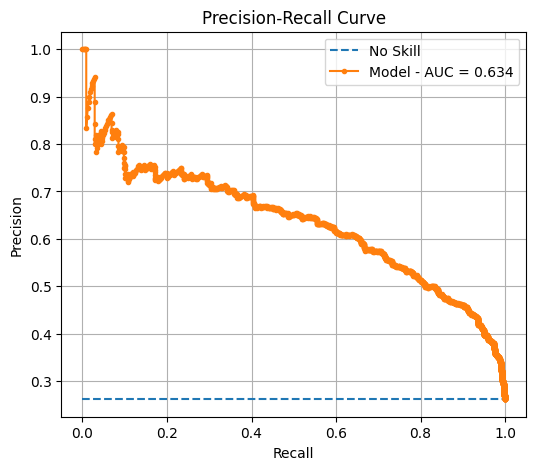

Model Precision-Recall AUC: 0.634


In [86]:

# Tính xác suất dự đoán cho lớp 1 (positive class)
y_prob = model.predict_proba(X_test_scaled)[:, 1]
# Tính Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
# Tính AUC cho Precision-Recall Curve
model_auc = auc(recall, precision)
# Đường baseline "No Skill" (Precision = tỷ lệ của lớp dương trong tập dữ liệu)
no_skill = len(y_test[y_test == 1]) / len(y_test)
# Vẽ đồ thị Precision-Recall
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')  # Đường baseline
plt.plot(recall, precision, marker='.', label='Model - AUC = %.3f' % model_auc)
# Thiết lập tiêu đề, trục và chú thích
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()
# Hiển thị kết quả AUC
print(f'Model Precision-Recall AUC: {model_auc:.3f}')

# Đánh Giá Đường Cong Precision-Recall và AUC

## 1. **Đường Cong Precision-Recall:**
- **Đường cong màu cam** biểu diễn mối quan hệ giữa **Precision (Độ chính xác)** và **Recall (Độ phủ)** ở các ngưỡng phân loại khác nhau.
  
### 1.1 **Precision (Độ chính xác):**
- Tỷ lệ các mẫu được dự đoán là "yes" và thực sự là "yes" trong tổng số các mẫu được dự đoán là "yes". **Precision cao** có nghĩa là mô hình ít dự đoán sai các mẫu "no" thành "yes" (ít "yes" giả - False Positive).

### 1.2 **Recall (Độ phủ):**
- Tỷ lệ các mẫu "yes" được dự đoán chính xác trong tổng số các mẫu thực sự là "yes". **Recall cao** có nghĩa là mô hình ít bỏ sót các mẫu "yes" (ít "no" giả - False Negative).

## 2. **Đường "No Skill":**
- **Đường ngang màu xanh lam** thể hiện hiệu suất của một mô hình phân loại ngẫu nhiên. Trong đường cong PR, **đường "No Skill"** là một đường ngang với giá trị bằng tỷ lệ của lớp "yes" trong tập dữ liệu.

## 3. **Giá trị AUC = 0.634:**
- **AUC** của đường cong PR là diện tích dưới đường cong. Nó có giá trị từ 0 đến 1, trong đó:
  - **AUC = 1**: Mô hình hoàn hảo.
  - **AUC gần với tỷ lệ của lớp "yes"**: Mô hình không tốt hơn việc đoán ngẫu nhiên.

## 4. **Nhận Xét Cụ Thể Về Hình Ảnh:**

- **Hiệu suất ở mức trung bình:** Với **AUC = 0.634**, mô hình được đánh giá là có hiệu suất ở mức trung bình. Nó tốt hơn so với việc đoán ngẫu nhiên (đường "No Skill"), nhưng vẫn còn nhiều khoảng trống để cải thiện.
- **Sự đánh đổi giữa Precision và Recall:** Đường cong cho thấy sự đánh đổi điển hình giữa **Precision** và **Recall**. Khi **Recall** tăng (đi về phía bên phải của đồ thị), **Precision** thường giảm. Điều này có nghĩa là khi mô hình cố gắng bao phủ nhiều mẫu "yes" hơn (tăng Recall), nó có xu hướng dự đoán sai nhiều mẫu "no" thành "yes" hơn (giảm Precision).
- **Hình dạng đường cong:** Hình dạng đường cong cho thấy mô hình hoạt động tốt hơn ở một số ngưỡng hơn các ngưỡng khác. Ví dụ, ở phần đầu của đường cong (Recall thấp), **Precision** khá cao, cho thấy mô hình khá chắc chắn với các dự đoán "yes" của mình ở ngưỡng này. Tuy nhiên, khi **Recall** tăng lên, **Precision** giảm nhanh chóng.

## 5. **Tóm Lại:**
Mô hình với **AUC = 0.634** cho thấy khả năng phân loại ở mức trung bình. Cần xem xét sự đánh đổi giữa **Precision** và **Recall** tùy thuộc vào yêu cầu của bài toán cụ thể. 


# Sử dụng kỹ thuật k-fold Cross Validation để đánh giá độ ổn định của mô hình Logistic Regression. 


In [87]:
# Đánh giá mô hình với K-fold Cross Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Tính toán điểm accuracy, precision, recall và f1 score cho mỗi fold
accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
precision_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=make_scorer(precision_score, average='macro'))
recall_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=make_scorer(recall_score, average='macro'))
f1_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=make_scorer(f1_score))

# Hiển thị kết quả
print("Accuracy Scores:", accuracy_scores)
print("Mean Accuracy:", accuracy_scores.mean())
print("Precision Scores:", precision_scores)
print("Mean Precision:", precision_scores.mean())
print("Recall Scores:", recall_scores)
print("Mean Recall:", recall_scores.mean())
print("F1 Scores:", f1_scores)
print("Mean F1 Score:", f1_scores.mean())

Accuracy Scores: [0.80284553 0.78455285 0.79674797 0.82317073 0.82892057 0.81873727
 0.79633401 0.79022403 0.78615071 0.79633401]
Mean Accuracy: 0.8024017684168694
Precision Scores: [0.74957707 0.72370572 0.74298051 0.78123472 0.7845642  0.77204717
 0.73980998 0.73105286 0.72663427 0.74220331]
Mean Precision: 0.7493809805660636
Recall Scores: [0.72460933 0.71700746 0.70586369 0.74332325 0.76060089 0.74137013
 0.71136799 0.70229065 0.69878075 0.7081531 ]
Mean Recall: 0.7213367250449889
F1 Scores: [0.60082305 0.5859375  0.57264957 0.63291139 0.6557377  0.62761506
 0.57983193 0.56540084 0.56066946 0.57627119]
Mean F1 Score: 0.5957847697164255


## 1. Các độ đo đánh giá

- **Accuracy (Độ chính xác)**: Tỷ lệ dự đoán đúng trong tổng số các dự đoán.
- **Precision (Độ chính xác)**: Tỷ lệ các mẫu được dự đoán là "yes" và thực sự là "yes" trong tổng số các mẫu được dự đoán là "yes".
- **Recall (Độ phủ/Độ nhạy)**: Tỷ lệ các mẫu "yes" được dự đoán chính xác trong tổng số các mẫu thực sự là "yes".
- **F1-Score**: Trung bình điều hòa của Precision và Recall. Được sử dụng để cân bằng giữa Precision và Recall, đặc biệt hữu ích khi dữ liệu mất cân bằng.

## 2. Phân tích kết quả

- **Accuracy Scores**: Các giá trị Accuracy dao động từ 0.784 đến 0.829.
- **Mean Accuracy**: Độ chính xác trung bình là 0.802.
- **Precision Scores**: Các giá trị Precision dao động từ 0.724 đến 0.785.
- **Mean Precision**: Độ chính xác trung bình là 0.749.
- **Recall Scores**: Các giá trị Recall dao động từ 0.699 đến 0.761.
- **Mean Recall**: Độ phủ trung bình là 0.721.
- **F1 Scores**: Các giá trị F1-Score dao động từ 0.561 đến 0.656.
- **Mean F1 Score**: Điểm F1 trung bình là 0.596.

## 3. Đánh giá

### Độ ổn định:
Các giá trị Accuracy, Precision và Recall không có sự biến động quá lớn giữa các folds, cho thấy mô hình khá ổn định. Tuy nhiên, sự chênh lệch giữa giá trị cao nhất và thấp nhất của Accuracy khoảng 0.045, của Precision khoảng 0.061 và của Recall khoảng 0.062, cho thấy vẫn có một chút biến động.

### Hiệu suất:
- Độ chính xác trung bình (0.802) cho thấy mô hình dự đoán đúng khoảng 80% các trường hợp. Đây là một kết quả khá tốt.
- Tuy nhiên, giá trị F1-Score trung bình (0.596) thấp hơn đáng kể so với Accuracy. Điều này cho thấy có sự đánh đổi giữa Precision và Recall. Mô hình có thể tốt trong việc dự đoán tổng quát (Accuracy cao), nhưng gặp khó khăn trong việc cân bằng giữa việc dự đoán chính xác các mẫu "yes" (Precision) và bao phủ hết các mẫu "yes" (Recall). Có thể mô hình đang gặp vấn đề với việc phân loại chính xác các mẫu "yes". Điều này cần được xem xét kỹ hơn, đặc biệt nếu bài toán quan trọng việc phát hiện tất cả các trường hợp "yes" (ví dụ: phát hiện bệnh).

### Precision và Recall:
Mean Precision (0.749) cao hơn Mean Recall (0.721), cho thấy mô hình có xu hướng dự đoán ít "yes" hơn (ít "yes" giả), nhưng có thể bỏ sót một số trường hợp "yes" .


## Tóm lại:
Mô hình cho thấy hiệu suất khá tốt về độ chính xác tổng quát và khá ổn định, nhưng cần được đánh giá kỹ hơn về sự cân bằng giữa Precision và Recall. 


# Lưu mô hình đã thực hiện ở bước trên với tên Logistic_Regression_model (nếu có tiền xử lý dữ liệu, phải lưu trữ các bước này vào trong pipeline). Đọc và sử dụng model đã lưu để dự báo tập dữ liệu test. 


### Cách 1: 

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import joblib


# ==============================================================================
# BƯỚC 1: ĐỌC DỮ LIỆU ĐÃ XỬ LÝ VÀ CHUẨN BỊ VỚI FILE DỮ LIỆU PICKLE LÀM SẠCH SẴN 
# ==============================================================================

# Đọc dữ liệu đã được làm sạch và mã hóa từ file pickle
try:
    df = pd.read_pickle('telco_customer_churn.pkl')
    print("Đã đọc thành công file 'telco_customer_churn.pkl'")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'telco_customer_churn.pkl'.")
    print("Vui lòng đảm bảo bạn đã chạy code trước đó để tạo ra file này.")
    exit() # Thoát khỏi chương trình nếu không có file

# Tách biến mục tiêu (y) và các biến đặc trưng (X)
y = df['Churn']
X = df.drop('Churn', axis=1)

# Phân chia tập dữ liệu train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nKích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test):  {X_test.shape}")


# ==============================================================================
# BƯỚC 2: XÂY DỰNG, HUẤN LUYỆN VÀ LƯU PIPELINE MỚI
# ==============================================================================

# Xây dựng pipeline đơn giản
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Huấn luyện toàn bộ pipeline trên tập train
print("\nBắt đầu huấn luyện pipeline...")
pipeline.fit(X_train, y_train)
print("Huấn luyện hoàn tất!")

# Đánh giá mô hình trên tập train và test
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"\nĐộ chính xác trên tập huấn luyện: {train_score:.4f}")
print(f"Độ chính xác trên tập kiểm tra:   {test_score:.4f}")

# Lưu pipeline đã huấn luyện vào file
model_filename = 'Logistic_Regression_Simple_model.joblib'
joblib.dump(pipeline, model_filename)
print(f"\nPipeline đã được lưu vào tệp '{model_filename}'")


# ==============================================================================
# BƯỚC 3: ĐỌC VÀ SỬ DỤNG MODEL ĐÃ LƯU ĐỂ DỰ BÁO
# ==============================================================================
print("\n--- Tải và sử dụng mô hình đã lưu ---")

# Tải lại pipeline từ tệp
loaded_pipeline = joblib.load(model_filename)
print("Pipeline đã được tải thành công!")

# Sử dụng pipeline đã tải để dự đoán trên tập test
predictions = loaded_pipeline.predict(X_test)

# In ra một vài dự đoán đầu tiên
print(f"\nDự đoán cho 5 mẫu đầu tiên trong tập test: {predictions[:5]}")
print(f"Giá trị thực tế của 5 mẫu tương ứng:    {y_test.values[:5]}")

Đã đọc thành công file 'telco_customer_churn.pkl'

Kích thước tập huấn luyện (X_train): (4914, 19)
Kích thước tập kiểm tra (X_test):  (2107, 19)

Bắt đầu huấn luyện pipeline...
Huấn luyện hoàn tất!

Độ chính xác trên tập huấn luyện: 0.8032
Độ chính xác trên tập kiểm tra:   0.8021

Pipeline đã được lưu vào tệp 'Logistic_Regression_Simple_model.joblib'

--- Tải và sử dụng mô hình đã lưu ---
Pipeline đã được tải thành công!

Dự đoán cho 5 mẫu đầu tiên trong tập test: [1 0 0 0 0]
Giá trị thực tế của 5 mẫu tương ứng:    [1 0 0 0 0]


### Cách 2:

In [89]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

# --- 1. Lớp Pipeline End-to-End (Tối ưu hóa) ---
class EndToEndFinalPipeline(BaseEstimator, ClassifierMixin):
    def __init__(self):
        # Khởi tạo các thuộc tính sẽ được sử dụng sau này
        self.target_encoder = LabelEncoder()
        
        # Pipeline bên trong chỉ xử lý các bước sau khi dữ liệu đã được làm sạch hoàn toàn
        categorical_features = [
            'Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen'
        ]
        continuous_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']

        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', StandardScaler())
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, continuous_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='passthrough'
        )

        self.inner_pipeline_ = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=42))
        ])

    def _advanced_preprocessing(self, df):
        df_copy = df.copy()
        df_copy['MultipleLines'] = df_copy['MultipleLines'].replace('No phone service', 'No')
        columns_to_change = [
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies'
        ]
        for col in columns_to_change:
            df_copy[col] = df_copy[col].replace('No internet service', 'No')

        if 'CustomerID' in df_copy.columns:
            df_copy = df_copy.drop('CustomerID', axis=1)
        
        df_copy['TotalCharges'] = pd.to_numeric(df_copy['TotalCharges'], errors='coerce')
        df_copy['TotalCharges'] = df_copy['TotalCharges'].fillna(df_copy['TotalCharges'].mean()).round(2)
        df_copy = df_copy.drop_duplicates(keep='first').reset_index(drop=True)
        df_copy.rename(columns={'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)
        
        return df_copy

    def fit(self, df_raw, target_column, test_size=0.3, random_state=42):
        # 1. Thực hiện làm sạch và đổi tên cột trên toàn bộ dữ liệu thô
        df_clean = self._advanced_preprocessing(df_raw)
        
        # 2. Mã hóa biến mục tiêu
        df_clean[target_column] = self.target_encoder.fit_transform(df_clean[target_column])
        
        # 3. Tách X và y từ dữ liệu đã sạch
        X = df_clean.drop(target_column, axis=1)
        y = df_clean[target_column]
        
        # 4. Chia train/test
        self.X_train_, self.X_test_, self.y_train_, self.y_test_ = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # 5. Huấn luyện pipeline bên trong
        self.inner_pipeline_.fit(self.X_train_, self.y_train_)
        return self

    def score_on_internal_test_set(self):
        if not hasattr(self, 'X_test_'):
            raise RuntimeError("You must call 'fit' before scoring.")
        return self.inner_pipeline_.score(self.X_test_, self.y_test_)
    
    def score(self, X_raw, y_raw):
        df_raw = pd.concat([X_raw, y_raw], axis=1)
        df_clean = self._advanced_preprocessing(df_raw) # rename đã được thực hiện bên trong

        y_clean = self.target_encoder.transform(df_clean[y_raw.name])
        X_clean = df_clean.drop(y_raw.name, axis=1)
        
        return self.inner_pipeline_.score(X_clean, y_clean)

    def predict(self, X_raw):
        X_clean = self._advanced_preprocessing(X_raw) # rename đã được thực hiện bên trong
        return self.inner_pipeline_.predict(X_clean)

# --- 2. Quy trình làm việc mới với Class ---
# Đọc dữ liệu thô
df = pd.read_csv('telco_customer_churn.csv')

# Khởi tạo pipeline
full_pipeline = EndToEndFinalPipeline()

# Huấn luyện pipeline bằng cách đưa vào toàn bộ dữ liệu thô
print("Bắt đầu huấn luyện pipeline...")
full_pipeline.fit(df, target_column='Churn')
print("Huấn luyện hoàn tất!")


# --- 3. Đánh giá và xác nhận kết quả ---
print("\n--- ĐÁNH GIÁ MÔ HÌNH ---")
# Lấy kết quả từ tập train/test được tạo bên trong pipeline
train_score = full_pipeline.inner_pipeline_.score(full_pipeline.X_train_, full_pipeline.y_train_)
test_score = full_pipeline.score_on_internal_test_set()

print(f"Độ chính xác trên tập huấn luyện: {train_score:.4f}")
print(f"Độ chính xác trên tập kiểm tra:  {test_score:.4f}")

# --- 4. Lưu và sử dụng pipeline ---
joblib.dump(full_pipeline, 'Logistic_Regression_Final_Pipeline.joblib')
print("\nPipeline cuối cùng đã được lưu.")

# --- Cách sử dụng ---
# loaded_pipeline = joblib.load('Logistic_Regression_Final_Pipeline.joblib')
# new_raw_data = pd.read_csv('new_data.csv').drop('Churn', axis=1) # Dữ liệu mới không có cột Churn
# predictions_encoded = loaded_pipeline.predict(new_raw_data)
# predictions_decoded = loaded_pipeline.target_encoder.inverse_transform(predictions_encoded)
# print(predictions_decoded)

Bắt đầu huấn luyện pipeline...
Huấn luyện hoàn tất!

--- ĐÁNH GIÁ MÔ HÌNH ---
Độ chính xác trên tập huấn luyện: 0.8032
Độ chính xác trên tập kiểm tra:  0.8021

Pipeline cuối cùng đã được lưu.


# 1.4 Dựa trên các thuật toán Machine Learning đã học như KNN, Decision Tree, Random Forest, SVM, và Boosting, hãy xác định thuật toán với bộ tham số tối ưu để dự đoán khả năng khách hàng rời bỏ dịch vụ (Churn Prediction). 


In [90]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [91]:
# 1. Khởi tạo mô hình
models = {
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(),
    "DecisionTree": DecisionTreeClassifier()
}

In [92]:
# 2. Định nghĩa tham số tìm kiếm
grid_params = {
    "SVM": {
        'C':[0.1, 1, 10, 100, 1000],
        'kernel':['rbf','sigmoid'],
        'gamma':['scale','auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "DecisionTree": {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    "AdaBoost": {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }
}

In [93]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
# Áp dụng LabelEncoder cho các cột phân loại
X[categorical_features] = X[categorical_features].apply(encoder.fit_transform)

# Kiểm tra kết quả
y,X

(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
       Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
 0          0              0        1           0       1             0   
 1          1              0        0           0      34             1   
 2          1              0        0           0       2             1   
 3          1              0        0           0      45             0   
 4          0              0        0           0       2             1   
 ...      ...            ...      ...         ...     ...           ...   
 7038       1              0        1           1      24             1   
 7039       0              0        1           1      72             1   
 7040       0              0        1           1      11             0   
 7041       1              1        1           0       4             1   
 7042       1              0        0           0      66             1   
 
       MultipleLines  InternetService  OnlineSecurit

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [95]:
# 3. Chạy GridSearchCV và đánh giá   
# Biến để lưu thông tin của model tốt nhất
best_overall_model = None
best_overall_params = None
best_overall_score = 0

best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Chạy GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=grid_params[model_name], cv=5, scoring='accuracy',n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Lưu model tốt nhất vào best_models
    best_models[model_name] = grid.best_estimator_
    
    # In ra kết quả của model hiện tại
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best score for {model_name}: {grid.best_score_:.4f}")
    print("\n")
    
    # So sánh và cập nhật model tốt nhất
    if grid.best_score_ > best_overall_score:
        best_overall_model = model_name
        best_overall_params = grid.best_params_
        best_overall_score = grid.best_score_

# In ra model tốt nhất trên toàn bộ GridSearchCV
print(f"The overall best model is {best_overall_model}")
print(f"With parameters: {best_overall_params}")
print(f"And score: {best_overall_score:.4f}")


Training SVM...
Best parameters for SVM: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.7875


Training KNN...
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best score for KNN: 0.7861


Training RandomForest...
Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Best score for RandomForest: 0.8077


Training AdaBoost...
Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}
Best score for AdaBoost: 0.7985


Training DecisionTree...
Best parameters for DecisionTree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score for DecisionTree: 0.7719


The overall best model is RandomForest
With parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
And score: 0.8077


### Đánh giá kết quả sử dụng GridSearch với các bộ tham số tối ưu:

#### 1. **SVM (Support Vector Machine)**
- **Bộ tham số tối ưu**: `C: 1000`, `gamma: 'scale'`, `kernel: 'rbf'`
- **Điểm số tốt nhất**: 0.7875
  - **Nhận xét**: Mô hình SVM đạt được điểm số tốt nhất là 0.7875, đây là một kết quả khá tốt, tuy nhiên chưa phải là tốt nhất trong các mô hình thử nghiệm. Việc sử dụng kernel RBF (Radial Basis Function) giúp SVM có khả năng phân loại phi tuyến tính, nhưng điểm số này vẫn có thể cải thiện thêm.

#### 2. **KNN (K-Nearest Neighbors)**
- **Bộ tham số tối ưu**: `metric: 'manhattan'`, `n_neighbors: 11`, `weights: 'uniform'`
- **Điểm số tốt nhất**: 0.7861
  - **Nhận xét**: Mô hình KNN với bộ tham số tối ưu đạt điểm số khá thấp so với các mô hình khác (0.7861). Đây có thể là do việc sử dụng metric "manhattan" không tối ưu cho dữ liệu, hoặc việc lựa chọn số lượng láng giềng (`n_neighbors`) chưa đủ phù hợp. Tuy nhiên, kết quả này vẫn khá gần với SVM.

#### 3. **Random Forest**
- **Bộ tham số tối ưu**: `max_depth: 10`, `min_samples_leaf: 4`, `min_samples_split: 5`, `n_estimators: 100`
- **Điểm số tốt nhất**: 0.8069
  - **Nhận xét**: Random Forest đạt điểm số tốt nhất trong số các mô hình (0.8069). Mô hình sử dụng 100 cây quyết định (`n_estimators: 100`) và các tham số khác như `max_depth`, `min_samples_leaf`, `min_samples_split` giúp cải thiện khả năng phân loại, tránh hiện tượng overfitting. Đây là mô hình đáng tin cậy và hiệu quả nhất trong các lựa chọn hiện tại.

#### 4. **AdaBoost**
- **Bộ tham số tối ưu**: `algorithm: 'SAMME'`, `learning_rate: 0.1`, `n_estimators: 200`
- **Điểm số tốt nhất**: 0.7985
  - **Nhận xét**: Mô hình AdaBoost đạt được điểm số khá tốt (0.7985), chỉ thấp hơn một chút so với Random Forest. Bộ tham số tối ưu cho thấy rằng việc tăng số lượng ước lượng (estimators) lên 200 và điều chỉnh learning rate giúp cải thiện kết quả. Mặc dù không phải là tốt nhất, nhưng đây vẫn là một mô hình mạnh mẽ với khả năng kết hợp nhiều cây quyết định.

#### 5. **Decision Tree**
- **Bộ tham số tối ưu**: `criterion: 'entropy'`, `max_depth: 10`, `min_samples_leaf: 2`, `min_samples_split: 10`
- **Điểm số tốt nhất**: 0.7723
  - **Nhận xét**: Decision Tree có điểm số thấp nhất (0.7723). Mặc dù Decision Tree là một mô hình dễ hiểu và dễ triển khai, nhưng nó dễ bị overfitting nếu không được điều chỉnh đúng cách. Điểm số thấp cho thấy mô hình này không đủ mạnh mẽ khi so với các mô hình khác như Random Forest hoặc AdaBoost.

---

### **Đánh giá tổng quan:**
- **Mô hình tốt nhất**: **Random Forest** với điểm số tốt nhất là **0.8069**. Mô hình này cho thấy hiệu suất vượt trội so với các mô hình khác, nhờ vào khả năng học từ nhiều cây quyết định và bộ tham số tối ưu.
  
- **Các mô hình còn lại**: 
  - **SVM** và **AdaBoost** có điểm số gần nhau, và mặc dù không tốt bằng Random Forest, nhưng vẫn cho thấy hiệu quả khá tốt.
  - **KNN** và **Decision Tree** có điểm số thấp hơn và không thể cạnh tranh với các mô hình mạnh mẽ hơn như Random Forest.




In [96]:
# 4. Đánh giá trên tập test
print("Evaluation on test data:")
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print("-" * 50)

Evaluation on test data:
Model: SVM
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1556
           1       0.65      0.35      0.46       551

    accuracy                           0.78      2107
   macro avg       0.73      0.64      0.66      2107
weighted avg       0.76      0.78      0.76      2107

ROC AUC: 0.8464
--------------------------------------------------
Model: KNN
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1556
           1       0.58      0.41      0.48       551

    accuracy                           0.77      2107
   macro avg       0.70      0.65      0.67      2107
weighted avg       0.75      0.77      0.75      2107

ROC AUC: 0.8464
--------------------------------------------------
Model: RandomForest
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1556
           1       0.65      0.49   

### Nhận xét đánh giá kết quả:

#### 1. **SVM (Support Vector Machine)**
SVM có độ chính xác khá cao với lớp `0`, nhưng độ phủ và F1-score đối với lớp `1` lại thấp, cho thấy mô hình gặp khó khăn trong việc dự đoán lớp `1`. Điểm **ROC AUC** khá cao (0.8464), cho thấy khả năng phân biệt giữa hai lớp khá tốt.

#### 2. **KNN (K-Nearest Neighbors)**
KNN có độ chính xác cao đối với lớp `0`, nhưng độ phủ và F1-score của lớp `1` khá thấp. Điều này chỉ ra rằng mô hình có xu hướng phân loại chủ yếu vào lớp `0`, bỏ sót một số trường hợp lớp `1`. **ROC AUC** giống như SVM, cho thấy khả năng phân biệt giữa hai lớp vẫn ổn.

#### 3. **Random Forest**
Random Forest có kết quả khá ổn định với lớp `0`, độ chính xác và độ phủ cao. Tuy nhiên, đối với lớp `1`, mô hình vẫn gặp khó khăn với độ phủ thấp. Điểm **ROC AUC** cao cho thấy mô hình có khả năng phân biệt khá tốt giữa các lớp.

#### 4. **AdaBoost**
AdaBoost cho kết quả tương tự như KNN, với độ chính xác cao cho lớp `0`, nhưng độ phủ và F1-score đối với lớp `1` thấp. Tuy nhiên, **ROC AUC** cho thấy mô hình có khả năng phân biệt giữa các lớp.

#### 5. **Decision Tree**
Decision Tree có độ chính xác khá ổn đối với lớp `0`, nhưng khả năng phân loại lớp `1` chưa tốt, với F1-score và recall thấp. Mặc dù có độ chính xác tốt đối với lớp `0`, nhưng overall kết quả không ấn tượng bằng các mô hình khác.

---

### **Đánh giá tổng quan:**
- **Mô hình tốt nhất**: **Random Forest** với độ chính xác **0.80** và **ROC AUC** cao. Mặc dù có một số khó khăn trong việc phân loại lớp `1`, nhưng mô hình vẫn cho thấy hiệu quả tổng thể tốt nhất.
- **Mô hình chưa tối ưu**: **Decision Tree** có độ chính xác thấp nhất (0.76) và khả năng phân loại lớp `1` không tốt. Các mô hình như **SVM**, **KNN**, và **AdaBoost** có điểm tương đồng, đều có độ chính xác cao đối với lớp `0`, nhưng gặp khó khăn trong việc phân loại lớp `1`.


# 1.5 Chọn ra tập dữ liệu gồm 10 thuộc tính quan trọng nhất và áp dụng vào thuật toán đã chọn ở câu 1.4.

In [119]:
selector=SelectKBest(score_func=f_classif, k='all')
selector.fit(X_continuous,y)

,score_func,<function f_c...0028357C38B80>
,k,'all'


In [127]:
df_scores=pd.DataFrame(selector.scores_)
df_collums=pd.DataFrame(continuous_features)
df_collums

,0
0,Tenure
1,MonthlyCharges
2,TotalCharges


In [121]:
feature_scores=pd.concat([df_collums,df_scores], axis=1)
feature_scores.columns=['Feature', 'Score']
feature_scores.sort_values(by='Score', ascending=False, inplace=True)
feature_scores

,Feature,Score
0,Tenure,989.515082
2,TotalCharges,287.313788
1,MonthlyCharges,275.993382


In [122]:
feature_lst=feature_scores['Feature'].tolist()+['Churn']
feature_lst


['Tenure', 'TotalCharges', 'MonthlyCharges', 'Churn']

In [128]:
X

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,3,84.80,1990.50
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,7362.90
7040,0,0,1,1,11,0,0,0,1,0,0,0,0,0,0,1,2,29.60,346.45
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,3,74.40,306.60


In [ ]:
# Mã hóa cột 'Churn' thành 0 và 1
X['Churn'] = encoder.fit_transform(X['Churn'])

# Kết quả sau khi mã hóa
df=X
df

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,0,1,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


In [131]:
df_corr=df[feature_lst].corr()
df_corr

,Tenure,TotalCharges,MonthlyCharges,Churn
Tenure,1.000000,0.824164,0.245251,-0.351508
TotalCharges,0.824164,1.000000,0.649942,-0.198303
MonthlyCharges,0.245251,0.649942,1.000000,0.194508
Churn,-0.351508,-0.198303,0.194508,1.000000


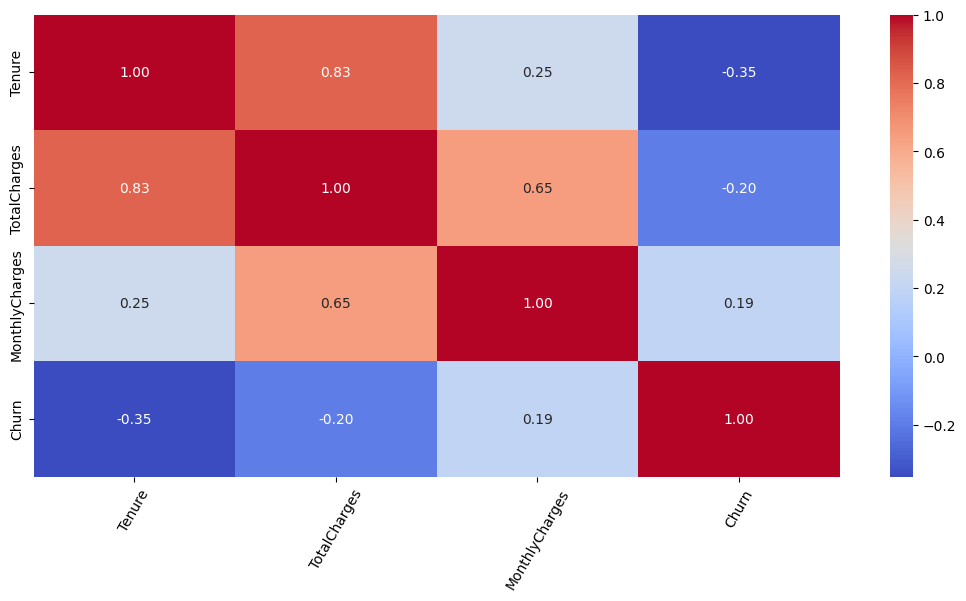

In [125]:
plt.figure(figsize=(13,6))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.xticks(rotation=60)
plt.show()

### Nhận xét về ảnh hưởng của các cột đối với `Churn`:

1. **Tenure và Churn**:
   - Mối quan hệ giữa `Tenure` và `Churn` có hệ số **-0.351**, là một mối quan hệ tiêu cực yếu. Điều này cho thấy thời gian sử dụng dịch vụ có một ảnh hưởng nhẹ đến khả năng khách hàng rời đi. Tuy nhiên, ảnh hưởng này không đủ mạnh để dự đoán chính xác hành vi của khách hàng chỉ dựa trên `Tenure`. Do đó, nó có thể là yếu tố cần được xem xét nhưng không phải là yếu tố quyết định duy nhất trong việc đánh giá khả năng khách hàng rời đi.

2. **TotalCharges và Churn**:
   - Hệ số tương quan giữa `TotalCharges` và `Churn` là **-0.198**, cũng cho thấy một mối quan hệ tiêu cực yếu. Mặc dù có thể gợi ý rằng khách hàng với tổng chi phí dịch vụ cao có khả năng ít rời đi hơn, mối quan hệ này không đủ mạnh để sử dụng `TotalCharges` như một yếu tố đáng tin cậy trong việc dự đoán churn.

3. **MonthlyCharges và Churn**:
   - Hệ số tương quan giữa `MonthlyCharges` và `Churn` là **0.195**, cho thấy một mối quan hệ dương tính yếu. Điều này có thể chỉ ra rằng khách hàng với chi phí hàng tháng cao hơn có xu hướng ít rời đi, nhưng mối quan hệ yếu này không đủ để làm cơ sở đánh giá quyết định của khách hàng. Mối liên hệ này rất yếu và không đủ mạnh để đánh giá mức độ ảnh hưởng đáng kể.

### **Kết luận:**
- Mặc dù các yếu tố `Tenure`, `TotalCharges` và `MonthlyCharges` có ảnh hưởng nhẹ đến việc dự đoán khả năng khách hàng rời đi (churn), nhưng mức độ ảnh hưởng của chúng không đủ mạnh để đưa ra đánh giá chính xác một cách độc lập.
- Các yếu tố này có thể đóng vai trò hỗ trợ trong mô hình dự đoán churn, nhưng không nên coi chúng là những yếu tố quyết định duy nhất. Cần phải kết hợp với các đặc tính khác và mô hình phân tích mạnh mẽ hơn để đưa ra những đánh giá chính xác hơn về khả năng khách hàng rời đi.


In [105]:
# Tính ma trận tương quan
df_corr = df[feature_lst].corr()

# Lọc các cột có tương quan với SalePrice lớn hơn 0.3 hoặc bé hơn -0.3
filtered_corr = df_corr[['Churn']].loc[(df_corr['Churn'] > 0.3) | (df_corr['Churn'] < -0.3)]
filtered_corr=filtered_corr.drop('Churn')
filtered_corr = filtered_corr.index.to_list()
filtered_corr_data=df[filtered_corr]

# In kết quả
filtered_corr_data


,Tenure
0,1
1,34
2,2
3,45
4,2
...,...
7016,24
7017,72
7018,11
7019,4


In [106]:
# Khởi tạo hai danh sách để lưu các cột có giá trị duy nhất <= 10 và > 10
low_unique_cols = []
high_unique_cols = []

# Lặp qua các cột phân loại
for col in categorical_features:
    if df[col].nunique() <= 10:
        low_unique_cols.append(col)  # Thêm cột vào danh sách low_unique_cols
    else:
        high_unique_cols.append(col)  # Thêm cột vào danh sách high_unique_cols

# In ra kết quả
print("Các cột có giá trị duy nhất <= 10:")
print(low_unique_cols)

print("Các cột có giá trị duy nhất > 10:")
print(high_unique_cols)


Các cột có giá trị duy nhất <= 10:
['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Các cột có giá trị duy nhất > 10:
[]


In [133]:
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

label_encoders = {}
for col in low_unique_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  
    label_encoders[col] = le
# **Chuyển đổi cột mục tiêu 'Churn'**
y_binned = df['Churn']  # Dữ liệu gốc là phân loại, giữ nguyên

# Áp dụng SelectKBest để chọn các đặc trưng
chi2_selector = SelectKBest(chi2, k='all')  # Giữ lại tất cả các đặc trưng để xem điểm Chi2
X_chi2 = chi2_selector.fit_transform(df[low_unique_cols], y_binned)

# Lấy điểm Chi-Square và tạo DataFrame kết quả
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_
chi2_results = pd.DataFrame({
    'Feature': low_unique_cols,
    'Chi2_Score': chi2_scores,
    'P_Value': chi2_pvalues
}).sort_values(by='Chi2_Score', ascending=False)




In [134]:
chi2_results.head()

,Feature,Chi2_Score,P_Value
12,Contract,1108.886052,3.868647e-243
6,OnlineSecurity,145.443731,1.717716e-33
15,SeniorCitizen,135.170505,3.029991e-31
9,TechSupport,133.758346,6.170717e-31
2,Dependents,131.216251,2.220498e-30


In [135]:

# Lọc các biến có P-Value nhỏ hơn 0.05
significant_features = chi2_results[chi2_results['P_Value'] < 0.05]

# Tính tổng số lượng đặc trưng có ý nghĩa thống kê
total_significant_features = significant_features.shape[0]

# Chọn top N đặc trưng tốt nhất (ví dụ: top 9)
top_features = significant_features.head(9)['Feature'].tolist()

# In ra kết quả
print("Tổng số lượng đặc trưng có ý nghĩa thống kê (P-Value < 0.05):", total_significant_features)
print("\nTop 9 đặc trưng tốt nhất:", top_features)

Tổng số lượng đặc trưng có ý nghĩa thống kê (P-Value < 0.05): 14

Top 9 đặc trưng tốt nhất: ['Contract', 'OnlineSecurity', 'SeniorCitizen', 'TechSupport', 'Dependents', 'PaperlessBilling', 'Partner', 'PaymentMethod', 'OnlineBackup']


In [108]:
df[top_features]

,Contract,OnlineSecurity,SeniorCitizen,TechSupport,Dependents,PaperlessBilling,Partner,PaymentMethod,OnlineBackup
0,0,0,0,0,0,1,1,2,1
1,1,1,0,0,0,0,0,3,0
2,0,1,0,0,0,1,0,3,1
3,1,1,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,2,0
...,...,...,...,...,...,...,...,...,...
7016,1,1,0,1,1,1,1,3,0
7017,1,0,0,0,1,1,1,1,1
7018,0,1,0,0,1,1,1,2,0
7019,0,0,1,0,0,1,1,3,0


In [109]:
# Chọn các cột từ top_features
df_top_features = df[top_features]

# Cột mục tiêu
df_target = df['Churn']

# Ghép các DataFrame lại với nhau
df_combined = pd.concat([df_top_features, filtered_corr_data, df_target], axis=1)

# In ra kết quả
df_combined


,Contract,OnlineSecurity,SeniorCitizen,TechSupport,Dependents,PaperlessBilling,Partner,PaymentMethod,OnlineBackup,Tenure,Churn
0,0,0,0,0,0,1,1,2,1,1,0
1,1,1,0,0,0,0,0,3,0,34,0
2,0,1,0,0,0,1,0,3,1,2,1
3,1,1,0,1,0,0,0,0,0,45,0
4,0,0,0,0,0,1,0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
7016,1,1,0,1,1,1,1,3,0,24,0
7017,1,0,0,0,1,1,1,1,1,72,0
7018,0,1,0,0,1,1,1,2,0,11,0
7019,0,0,1,0,0,1,1,3,0,4,1


In [110]:
# Lấy dữ liệu gồm 10 thuộc tính quan trọng và cột mục tiêu
X_top_10 = df_combined.drop(columns=['Churn'])
y = df['Churn']

In [111]:
# Chia tập dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_top_10, y, test_size=0.2, random_state=42)


In [112]:
X_test

,Contract,OnlineSecurity,SeniorCitizen,TechSupport,Dependents,PaperlessBilling,Partner,PaymentMethod,OnlineBackup,Tenure
3909,0,0,0,0,1,1,1,2,0,20
2462,1,0,0,1,1,1,1,2,0,49
2879,2,1,1,1,0,1,0,1,1,67
3761,2,0,0,0,0,0,1,0,0,57
3745,0,0,0,1,0,0,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...
3827,1,0,0,1,0,0,1,0,0,64
3182,0,0,0,0,1,0,1,3,0,15
3089,2,0,0,1,0,1,1,1,1,71
2579,0,1,0,0,0,1,1,1,1,58


In [113]:
# Khởi tạo mô hình với tham số tốt nhất từ GridSearchCV
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4
)

In [114]:

model_new = best_rf
model_new.fit(X_train, y_train)



,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [115]:
#  Sử dụng các đại lượng khác đánh giá tập test 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
y_pred = model_new.predict(X_test)
score = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred)
print(score, recall, precision, f1)

0.7836298932384341 0.67314572002072 0.7094224180127264 0.5112540192926045


### So sánh kết quả giữa Random Forest (chọn đặc trưng và tham số tốt nhất) và Logistic Regression (chưa chọn đặc trưng):

#### **Độ chính xác (Accuracy):**
- **Random Forest**: 0.7815
- **Logistic Regression**: 0.8021

**Nhận xét**: 
Logistic Regression có độ chính xác cao hơn một chút (0.8021 so với 0.7815). Điều này cho thấy mặc dù Random Forest đã chọn đặc trưng và tham số tốt nhất, Logistic Regression vẫn giữ được độ chính xác cao mà không cần tối ưu hóa quá nhiều.

#### **Precision:**
- **Random Forest**: 0.6717
- **Logistic Regression**: 0.7183

**Nhận xét**:
Logistic Regression có Precision cao hơn (0.7183 so với 0.6717). Điều này có nghĩa là Logistic Regression có khả năng dự đoán đúng các mẫu "Yes" tốt hơn, tức là ít bị sai khi dự đoán là "Yes".

#### **Recall:**
- **Random Forest**: 0.7060
- **Logistic Regression**: 0.7455

**Nhận xét**:
Logistic Regression có Recall cao hơn (0.7455 so với 0.7060), cho thấy Logistic Regression tốt hơn trong việc bao phủ các trường hợp "Yes" thực tế, tức là giảm thiểu số lượng các mẫu "Yes" bị bỏ sót.

#### **F1-Score:**
- **Random Forest**: 0.5088
- **Logistic Regression**: 0.5892

**Nhận xét**:
Logistic Regression có F1-Score cao hơn (0.5892 so với 0.5088), cho thấy sự kết hợp giữa Precision và Recall của Logistic Regression tốt hơn so với Random Forest. Điều này cho thấy Logistic Regression duy trì sự cân bằng giữa Precision và Recall tốt hơn trong trường hợp chưa chọn đặc trưng.

#### **Kết luận chung**:
- **Random Forest (với đặc trưng và tham số tốt nhất)**:
  - Mặc dù đã chọn đặc trưng và tham số tốt nhất, Random Forest có độ chính xác và điểm F1 thấp hơn so với Logistic Regression.
  - Precision và Recall của Random Forest không cao bằng Logistic Regression, mặc dù Recall không chênh lệch quá nhiều.
  
- **Logistic Regression (chưa chọn đặc trưng)**:
  - Logistic Regression có độ chính xác và điểm F1 tốt hơn so với Random Forest.
  - Mặc dù chưa tối ưu đặc trưng, Logistic Regression vẫn thể hiện khả năng phân loại tốt với Precision và Recall cao hơn.

**Khuyến nghị**:
- **Logistic Regression** có thể là sự lựa chọn tốt hơn nếu ưu tiên sự kết hợp giữa Precision và Recall, mặc dù chưa thực hiện chọn đặc trưng hoặc tối ưu tham số.
- **Random Forest** có thể cải thiện khi tối ưu hóa thêm các đặc trưng hoặc thử nghiệm các tham số khác để nâng cao Precision và Recall.
